In [25]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pennylane as qml
import pennylane.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime

import json

SEED = 42
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(seed = SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(f"Device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [27]:
class MakingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]
    return image, label

  def __len__(self):
      return len(self.y)


class TrainTestLoader(object):
  def __init__(self, data_type="MNIST"):
    self.data = data_type

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.data == "MNIST":
      download_root = "./MNIST_DATASET"
      MNIST_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = MNIST(download_root,
                        train=True,
                        download=True,
                        transform=MNIST_transform)

      self.test_data = MNIST(download_root,
                        train=False,
                        download=True,
                        transform=MNIST_transform)

      train_X = self.training_data.data / 255.0
      train_y = self.training_data.targets

      test_X = self.test_data.data / 255.0
      test_y = self.test_data.targets

      # 0과 1에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==0) | (train_y==1)]
      self.train_y = train_y[(train_y==0) | (train_y==1)]
      self.test_X = test_X[(test_y==0) | (test_y==1)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==1)][:1000]


  def scale_pca(self, size):
    
    ###여기에 standardscaler 있었는데 그냥 안 함
    if self.data == "MNIST":
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2]))

      pca = PCA(n_components = size)
      train_X = pca.fit_transform(train_X)
      test_X = pca.transform(test_X)
      self.train_X = torch.Tensor(train_X)
      self.test_X = torch.Tensor(test_X)
      if size <= 30:
        ### Rescale for angle embedding 원본
        self.train_X = torch.Tensor((train_X - train_X.min())\
                                    * (np.pi / (train_X.max() - train_X.min())))
        self.test_X = torch.Tensor((test_X - test_X.min())\
                                   * (np.pi / (test_X.max() - test_X.min())))

  def scale_resize(self, size):
    if self.data == "MNIST":
      size = int(np.sqrt(size))
      t = transforms.Resize(size=(size, size))
      train_X = t(self.train_X)
      test_X = t(self.test_X)

      self.train_X = train_X.reshape((train_X.shape[0],
                                     train_X.shape[1]*train_X.shape[2]))
      self.test_X = test_X.reshape((test_X.shape[0],
                                     test_X.shape[1]*test_X.shape[2]))

  def return_dataset(self):
      return MakingDataset(self.train_X, self.train_y), MakingDataset(self.test_X, self.test_y)

  # def save(self):
  #     self.training_data.to_csv("./training_data.csv", index = False)
  #     self.test_data.to_csv("./test_data.csv", index = False)

  # def load(self):
  #     self.training_data = read_csv("./training_data.csv")
  #     self.test_data = read_csv("./test_data.csv")



In [28]:
class EmbeddingMethod():
  def __init__(self, n_qubits = 8, embedding_type = "Amplitude"):
    self.n_qubits = n_qubits
    self.embedding_type = embedding_type
  
  def embed_data (self, inputs):
    if self.embedding_type == "Amplitude": # need (2^n_qubits) features
      qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits),
                           pad_with=0, normalize=True)
      
    elif self.embedding_type == 'Angle-compact':
      qml.AngleEmbedding(inputs[:8], wires=range(self.n_qubits), rotation='X')
      qml.AngleEmbedding(inputs[8:16], wires=range(self.n_qubits), rotation='Y')
      
    elif self.embedding_type == "HybridAngle_2":
      N = 3  # 3 classical bits in 2 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      X3 = inputs[2*N:3*N]
      X4 = inputs[3*N:4*N]
      self.Angular_Hybrid_2(X1, wires=[0,1])
      self.Angular_Hybrid_2(X2, wires=[2,3])
      self.Angular_Hybrid_2(X3, wires=[4,5])
      self.Angular_Hybrid_2(X4, wires=[6,7])

    elif self.embedding_type == "HybridAngle_4":
      N = 15 # 15 classical data in 4 qubits
      X1 = inputs[:N]
      X2 = inputs[N:2*N]
      self.Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
      self.Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])


  # Hybrid Angle Embedding
  
  def Angular_Hybrid_2(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])
  
  def Angular_Hybrid_4(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])



In [29]:
# Unitary Ansatze for Convolutional Layer

class U_TTN():  # Convolutional circuit 1 - 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    
class U_5(): # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_6():  # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_9():  # 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

class U_13():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])

class U_14():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])

class U_15():  # 4 params
  def __init__(self) -> None:
    self.num_params = 4
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

class U_SO4():  # Convolutional circuit 6 - 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])

class U_SU4(): # Convolutional circuit 9 - 15 params
  def __init__(self) -> None:
    self.num_params = 15
  
  def apply(self, params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


  # Pooling Layer
class Pooling_ansatz1(): #2 params
  def __init__(self) -> None:
      self.num_params = 2
  def apply(self, params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

class Pooling_ansatz2(): #0 params
  def __init__(self) -> None:
    self.num_params = 0
  def apply(self, params, wires):
    qml.CRZ(wires=[wires[0], wires[1]])

class Pooling_ansatz3(): #3 params
  def __init__(self) -> None:
    self.num_params = 3
  def apply(self, *params, wires):
    qml.CRot(*params, wires=[wires[0], wires[1]])



In [30]:
class QCNN(nn.Module):
  def __init__(self, n_qubits, embedding_type, conv_ansatz, pooling_ansatz, cost_fn):
    super(QCNN, self).__init__()
    self.n_qubits = n_qubits
    self.cost_fn = cost_fn
    self.embedding_method = EmbeddingMethod(n_qubits = n_qubits,
                                            embedding_type = embedding_type)
    if conv_ansatz == "U_TTN":
      self.conv_ansatz = U_TTN()
    elif conv_ansatz == "U_5":
      self.conv_ansatz = U_5()
    elif conv_ansatz == "U_6":
      self.conv_ansatz = U_6()
    elif conv_ansatz == "U_9":
      self.conv_ansatz = U_9()
    elif conv_ansatz == "U_13":
      self.conv_ansatz = U_13()
    elif conv_ansatz == "U_14":
      self.conv_ansatz = U_14()
    elif conv_ansatz == "U_15":
      self.conv_ansatz = U_15()
    elif conv_ansatz == "U_SO4":
      self.conv_ansatz = U_SO4()
    elif conv_ansatz == "U_SU4":
      self.conv_ansatz = U_SU4()


    if pooling_ansatz == "Pooling_ansatz1":
      self.pooling_ansatz = Pooling_ansatz1()
    elif pooling_ansatz == "Pooling_ansatz2":
      self.pooling_ansatz = Pooling_ansatz2()
    elif pooling_ansatz == "Pooling_ansatz3":
      self.pooling_ansatz = Pooling_ansatz3()
    
    dev = qml.device("default.qubit", wires=self.n_qubits)

    weight_shapes = { "weights1": (self.conv_ansatz.num_params,),
                      "weights2": (self.pooling_ansatz.num_params,),
                      "weights3": (self.conv_ansatz.num_params,),
                      "weights4": (self.pooling_ansatz.num_params,),
                      "weights5": (self.conv_ansatz.num_params,),
                      "weights6": (self.pooling_ansatz.num_params,)}

    @qml.qnode(dev, interface="torch")
    def qnode(inputs, weights1, weights2, weights3,
                    weights4, weights5, weights6):
      self.embedding_method.embed_data(inputs)

      self.conv_layer1(weights1)
      self.pooling_layer1(weights2)
      self.conv_layer2(weights3)
      self.pooling_layer2(weights4)
      self.conv_layer3(weights5)
      self.pooling_layer3(weights6)

      if self.cost_fn == "mse":
        return qml.expval(qml.PauliZ(4))
      elif self.cost_fn == "cross_entropy":
        return qml.probs(wires=4)

    init_method = torch.nn.init.normal_
    self.model = qml.qnn.TorchLayer(qnode, weight_shapes,
                                          init_method=init_method)
    
    ########################### print model ####################################
    inputs = np.random.rand(setting.scaled_dim)
    a = np.random.rand(self.conv_ansatz.num_params,)
    b = np.random.rand(self.pooling_ansatz.num_params,)
    c = np.random.rand(self.conv_ansatz.num_params,)
    d = np.random.rand(self.pooling_ansatz.num_params,)
    e = np.random.rand(self.conv_ansatz.num_params,)
    f = np.random.rand(self.pooling_ansatz.num_params,)

    fig, ax = qml.draw_mpl(qnode)(inputs, a,b,c,d,e,f)
    plt.show()
    ########################### print model ####################################

  def forward(self, data):
    return self.model(data)

  # Convolutional layers
  def conv_layer1(self, params):
    self.conv_ansatz.apply(params, wires=[0, 7])
    for i in range(0, 8, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
  
  def conv_layer2(self, params):
    self.conv_ansatz.apply(params, wires=[0, 6])
    self.conv_ansatz.apply(params, wires=[0, 2])
    self.conv_ansatz.apply(params, wires=[4, 6])
    self.conv_ansatz.apply(params, wires=[2, 4])
  
  def conv_layer3(self, params):
    self.conv_ansatz.apply(params, wires=[0,4])

  # Pooling layers
  def pooling_layer1(self, params):
      for i in range(0, 8, 2):
        self.pooling_ansatz.apply(params, wires=[i + 1, i])

  def pooling_layer2(self, params):
    self.pooling_ansatz.apply(params, wires=[2,0])
    self.pooling_ansatz.apply(params, wires=[6,4])

  def pooling_layer3(self, params):
    self.pooling_ansatz.apply(params, wires=[0,4])



In [31]:
class Trainer():
  def __init__(self, setting):
    self.setting = setting
    self.loss_list = []
    self.history_of_parameters = [] 
    self.total_time = None

  # iter mode
  def training_model(self, model, train_loader)->None:
    optimizer = self.setting.make_optimizer(model.parameters())
    start_t = time.time()
    iter = 0
    for epoch in range(self.setting.EPOCHS):
      for inputs, labels in train_loader:
        if iter == self.setting.train_iter:
          break

        inputs = inputs.to(torch.float64).to(device)
        if self.setting.cost_fn == "mse":
          labels = 2*labels.to(torch.float64).to(device) - 1  # label을 1과 -1로 변환
        elif self.setting.cost_fn == "cross_entropy":
          # 0은 [1,0]으로 1은 [0,1]로 변환
          labels = nn.functional.one_hot(labels).to(torch.float64).to(device)

        optimizer.zero_grad()
        pred = model(inputs)
        loss = self.setting.criterion(pred, labels)
        loss.backward()
        optimizer.step()

        current_param_list = []
        for current_param in model.parameters():
          for current_param_element in current_param.detach().cpu().reshape(-1,1):
            current_param_list.append(current_param_element.item())

        self.history_of_parameters.append(current_param_list)
        np.save(self.setting.filepath+'/'+f'param_of_iter{iter}', current_param_list)

        self.loss_list.append(loss.item())
        # self.setting.writer.add_scalar('training loss', loss.item(), iter)
        
        if (iter+1)%10 == 0:
          print(f"Iteration {iter+1:>3} loss: {loss.item()}")
        iter += 1
    ### train ends
    self.setting.writer.close()
    end_t = time.time()
    sec = end_t - start_t
    self.total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
    print(f"Training during {self.setting.train_iter} iterations finishes (taken time: {self.total_time}) ")



In [32]:
class Tester():
  def __init__(self, setting):
    self.setting = setting
    self.accuracy = 0
  
  def testing_model(self, model, test_loader)->None:
    with torch.no_grad():
      if self.setting.cost_fn == "mse":
        for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = 2*labels.to(torch.float64).to(device) - 1  # label을 1과 -1로 변환
          pred = model(inputs.to(torch.float64))
          correct = pred*labels > 0 #곱했을 때 부호가 같으면 정답
          self.accuracy = sum(correct) / len(correct)
          print(f"Test socre: {self.accuracy}")
      elif self.setting.cost_fn == "cross_entropy":
        for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          pred = model(inputs.to(torch.float64))
          pred = pred[:,0] < pred[:,1]
          # 0은 False, 1은 True
          correct = pred == labels
          self.accuracy = (sum(correct) / len(correct)).item()
          print(f"Test socre: {self.accuracy}")



In [33]:
def saving_summary(setting, trainer, tester):
  with open(setting.filepath+"/"+"summary.json","w") as fp:
    json.dump(dict(
        loss = trainer.loss_list,
        total_time = trainer.total_time,
        accuracy = tester.accuracy
    ), fp = fp)

    

In [34]:
class Setting():

  def __init__(self, data_type="MNIST", n_qubits=8, embedding_type="Amplitude",
               scaling_method = "pca", scaled_dim = 256, EPOCHS = 3,
               train_iter = 200, BATCH_SIZE = 25, LEARNING_RATE = 0.01,
              conv_ansatz="U_TTN",
               pooling_ansatz="Pooling_ansatz1", cost_fn="cross_entropy",
               filepath="/content/drive/MyDrive/박경덕교수님연구실/QCNN_with_gpu"):
    self.data_type=data_type
    self.n_qubits=n_qubits
    self.embedding_type=embedding_type
    self.scaling_method = scaling_method
    self.scaled_dim = scaled_dim
    self.EPOCHS = EPOCHS
    self.train_iter = train_iter
    self.BATCH_SIZE = BATCH_SIZE
    self.LEARNING_RATE = LEARNING_RATE
    self.conv_ansatz=conv_ansatz
    self.pooling_ansatz=pooling_ansatz
    self.cost_fn=cost_fn
    if cost_fn == "mse":
      self.criterion = nn.MSELoss()
    elif cost_fn == "cross_entropy":
      self.criterion = nn.CrossEntropyLoss()

 
    loader = TrainTestLoader(data_type=data_type)
    if self.scaling_method == "pca":
      loader.scale_pca( size = scaled_dim)
    elif self.scaling_method == "resize":
      loader.scale_resize( size=scaled_dim )
    self.train_data, self.test_data = loader.return_dataset()
    # print data sizes
    print(f"Train set #: {len(self.train_data)}")
    print(f"Test set #:  {len(self.test_data)}")

    
    self.filepath = filepath +\
            f"/{scaling_method}_{embedding_type}_{conv_ansatz}_{cost_fn}_result"
    
    if os.path.exists(self.filepath) == False:
        os.makedirs(self.filepath)
    self.writer = SummaryWriter(log_dir=self.filepath)
  
  def make_model(self):
    return QCNN(n_qubits = self.n_qubits,
                embedding_type = self.embedding_type,
                conv_ansatz = self.conv_ansatz,
                pooling_ansatz = self.pooling_ansatz,
                cost_fn = self.cost_fn)

  def make_optimizer(self, param):
    return optim.Adam(param, lr = self.LEARNING_RATE)

  def make_train_loader(self):
    return DataLoader(self.train_data, batch_size = self.BATCH_SIZE, shuffle=True)

  def make_test_loader(self):
    return DataLoader(self.test_data, batch_size = len(self.test_data), shuffle=False)



Train set #: 12665
Test set #:  1000


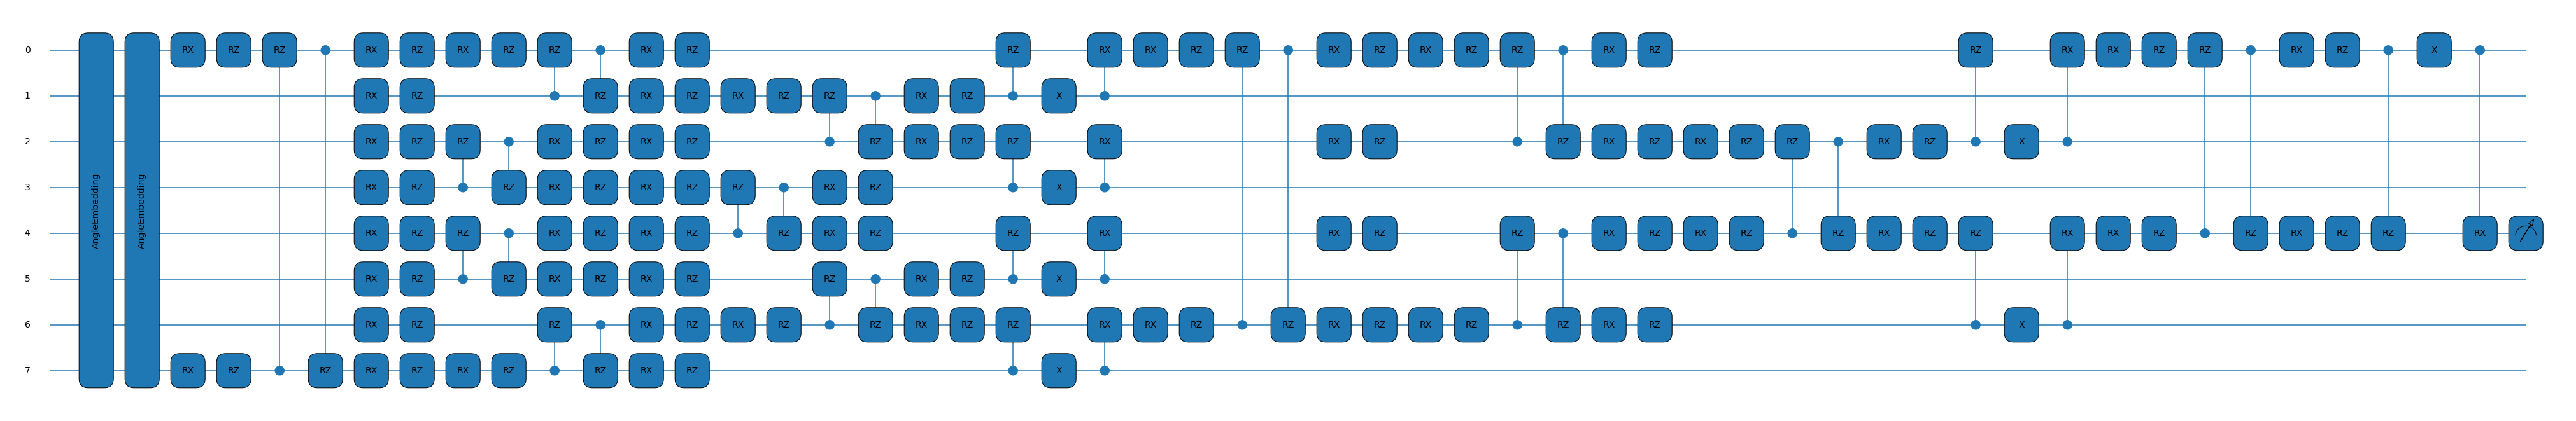

In [35]:
############################### hyper param ###################################
data_type = "MNIST"
n_qubits = 8
#### "Amplitude" - 256, "Angle-compact"-16, "HybridAngle_2"-12, "HybridAngle_4"-30
embedding_type="Angle-compact"
scaling_method = "pca"  #### "pca" or "resize" ####
scaled_dim = 16
EPOCHS = 3
train_iter = 200
BATCH_SIZE = 25
LEARNING_RATE = 0.01
#### "U_TTN", "U_5", "U_6", "U_9", "U_13", "U_14", "U_15", "U_SO4", "U_SU4"
conv_ansatz = "U_5"
pooling_ansatz = "Pooling_ansatz1" #### "Pooling_ansatz1","Pooling_ansatz2","Pooling_ansatz3"
cost_fn = "cross_entropy" #### "mse", "cross_entropy"

#######file path 필요하면 수정###########
filepath="/content/drive/MyDrive/박경덕교수님연구실/QCNN_with_gpu"
############################### hyper param ###################################


setting = Setting(data_type=data_type,
                  n_qubits=n_qubits,
                  embedding_type=embedding_type,
                  scaling_method = scaling_method,
                  scaled_dim = scaled_dim,
                  EPOCHS = EPOCHS,
                  train_iter = train_iter,
                  BATCH_SIZE = BATCH_SIZE,
                  LEARNING_RATE = LEARNING_RATE,
                  conv_ansatz=conv_ansatz,
                  pooling_ansatz=pooling_ansatz,
                  cost_fn=cost_fn,
                  filepath=filepath)

train_loader = setting.make_train_loader()
test_loader = setting.make_test_loader()

model = setting.make_model().to(device)


In [36]:
init_param = model.parameters()
for i in init_param:
  print(np.array(i.detach().cpu()))

[ 0.33669037  0.12880941  0.23446237  0.23033303 -1.12285638 -0.18632829
  2.20820141 -0.63799703  0.46165723  0.26735088]
[0.53490466 0.80935723]
[ 1.11029029 -1.68979895 -0.98895991  0.95797181  1.32213509  0.81718975
 -0.76583862 -0.75062233  1.35254776  0.68632191]
[-0.32775864  0.79496872]
[ 0.28151956  0.05616354  0.52271605 -0.23835687 -0.04990335  0.52633697
 -0.00849882  0.72906059  0.13314196  0.86397767]
[-1.01567471 -0.88874853]


# train model






In [37]:
############ train model ###########
trainer = Trainer(setting = setting)
trainer.training_model(model=model, train_loader=train_loader)


Iteration  10 loss: 0.6610160438877227
Iteration  20 loss: 0.5656488967712247
Iteration  30 loss: 0.5914839443822222
Iteration  40 loss: 0.5356376679905229
Iteration  50 loss: 0.5171778637339932
Iteration  60 loss: 0.5123531433968794
Iteration  70 loss: 0.4640599395897712
Iteration  80 loss: 0.4617387921678189
Iteration  90 loss: 0.4550090081230098
Iteration 100 loss: 0.44136913663141
Iteration 110 loss: 0.44335626557973656
Iteration 120 loss: 0.44819367273776756
Iteration 130 loss: 0.43016057337402014
Iteration 140 loss: 0.4177510767577849
Iteration 150 loss: 0.4224938055157236
Iteration 160 loss: 0.4268017688060049
Iteration 170 loss: 0.44435812228417215
Iteration 180 loss: 0.4376371907770676
Iteration 190 loss: 0.4149269005899454
Iteration 200 loss: 0.3984196850380737
Training during 200 iterations finishes (taken time: 0:17:34) 


In [38]:
### params after training
for i in model.parameters():
  print(np.array(i.detach().cpu()))


[ 1.68680981e-01  5.88815436e-02 -3.34998697e-01 -1.12526916e-01
 -5.05943716e-01  4.91932034e-01  1.99713802e+00 -1.88414425e-01
  5.23541391e-01  1.26169645e-03]
[ 0.51817775 -0.28279564]
[ 1.70557964 -1.32277787 -0.73317844  0.42626697  2.14649415  1.08460951
 -0.52623707 -0.56918609  0.83502716  1.08109832]
[0.35723904 0.25639603]
[ 0.4760493   0.01882244  1.32306266 -0.7552231  -0.50761425 -0.28318045
 -0.21271822  0.63714886  0.13277031  0.66145837]
[-1.01544917 -0.64053243]


In [39]:
############ test model ###########
tester = Tester(setting = setting)
tester.testing_model(model, test_loader)


Test socre: 0.9860000610351562


In [40]:
saving_summary(setting, trainer, tester)

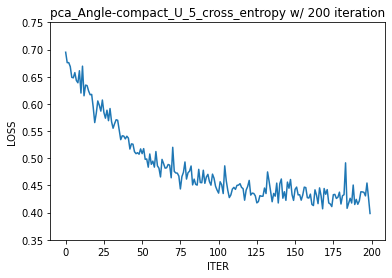

In [44]:
############### loss plot ################

plt.plot(trainer.loss_list)
plot_title = "_".join(setting.filepath.split("/")[-1].split("_")[:-1])
plt.title(f"{plot_title} w/ {str(setting.train_iter)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.35, 0.75))

plt.show()


In [42]:
print("_".join(setting.filepath.split("/")[-1].split("_")[:-1]))

pca_Angle-compact_U_5_cross_entropy


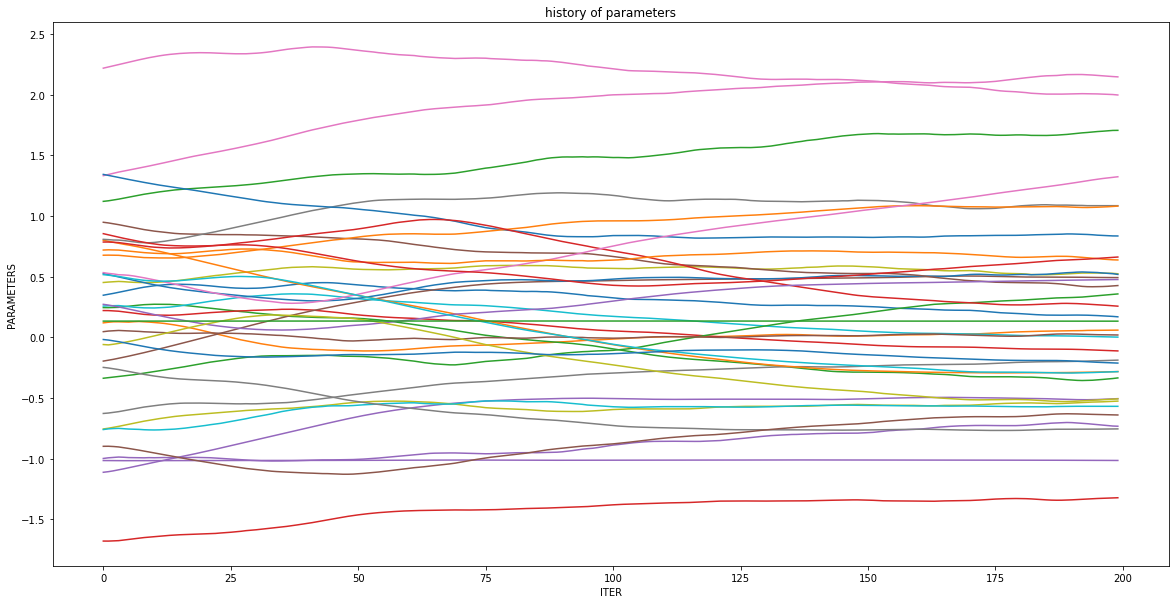

In [45]:
################## history of parameters ##################
plt.figure(figsize = (20,10))
plt.plot(trainer.history_of_parameters)
plt.title("history of parameters")
plt.xlabel("ITER")
plt.ylabel("PARAMETERS")
plt.show()

